<a href="https://colab.research.google.com/github/PanavShah1/deep_learning_projects/blob/main/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('AMZN (1).csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1.443120e+09
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,2.940000e+08
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,1.221360e+08
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,1.093440e+08
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,3.770640e+08
...,...,...,...,...,...,...,...
6809,2024-06-06,181.750000,185.000000,181.490005,185.000000,185.000000,3.137120e+07
6810,2024-06-07,184.899994,186.289993,183.360001,184.300003,184.300003,2.802150e+07
6811,2024-06-10,184.070007,187.229996,183.789993,187.059998,187.059998,3.449450e+07
6812,2024-06-11,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6809,2024-06-06,185.000000
6810,2024-06-07,184.300003
6811,2024-06-10,187.059998
6812,2024-06-11,NaN


In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [46]:
data['Date'] = pd.to_datetime(data['Date'])
data

<ipython-input-46-e4b191666380>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6809,2024-06-06,185.000000
6810,2024-06-07,184.300003
6811,2024-06-10,187.059998
6812,2024-06-11,NaN


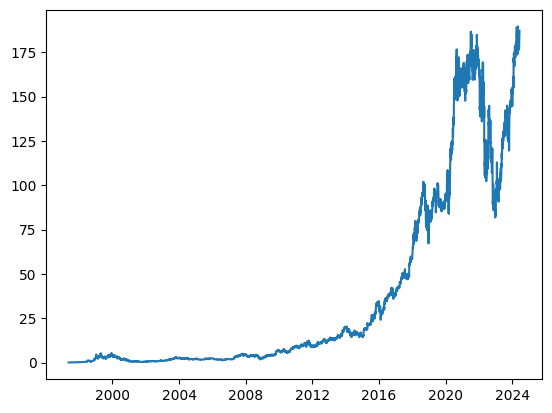

In [47]:
plt.plot(data['Date'], data['Close'])

In [48]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df)
  df['Date'] = pd.to_datetime(df['Date'])

  df.set_index('Date', inplace=True)

  for i in range(1, n_steps+1):
    df[f"Close(t-{i})"] = df["Close"].shift(i)

  df.dropna(inplace=True)

  return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, 7)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2024-06-04,179.339996,178.339996,176.440002,179.320007,182.020004,182.149994,180.750000,181.050003
2024-06-05,181.279999,179.339996,178.339996,176.440002,179.320007,182.020004,182.149994,180.750000
2024-06-06,185.000000,181.279999,179.339996,178.339996,176.440002,179.320007,182.020004,182.149994


In [49]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.85000000e+02, 1.81279999e+02, 1.79339996e+02, ...,
        1.79320007e+02, 1.82020004e+02, 1.82149994e+02],
       [1.84300003e+02, 1.85000000e+02, 1.81279999e+02, ...,
        1.76440002e+02, 1.79320007e+02, 1.82020004e+02],
       [1.87059998e+02, 1.84300003e+02, 1.85000000e+02, ...,
        1.78339996e+02, 1.76440002e+02, 1.79320007e+02]])

In [50]:
shifted_df_as_np.shape

(6805, 8)

In [51]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scalar.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[-0.99991201, -0.999956  , -1.        , ..., -0.99983503,
        -0.99982404, -0.99970306],
       [-0.9999395 , -0.99991201, -0.99994501, ..., -0.99987353,
        -0.99983503, -0.99982404],
       [-0.99995326, -0.9999395 , -0.99990102, ..., -0.99998351,
        -0.99987353, -0.99983503],
       ...,
       [ 0.95248884,  0.91321293,  0.8927309 , ...,  0.89251986,
         0.92102637,  0.9223988 ],
       [ 0.94509824,  0.95248884,  0.91321341, ...,  0.86211283,
         0.89251986,  0.92102637],
       [ 0.97423837,  0.94509824,  0.9524891 , ...,  0.88217292,
         0.86211283,  0.89251986]])

In [52]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((6805, 7), (6805,))

In [53]:
X = dc(np.flip(X, axis=1))
X.shape

(6805, 7)

In [54]:
split_index = int(len(X) * 0.95)
split_index

6464

In [55]:
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6464, 7), (341, 7), (6464,), (341,))

In [56]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6464, 7, 1), (341, 7, 1), (6464, 1), (341, 1))

In [57]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6464, 7, 1]),
 torch.Size([341, 7, 1]),
 torch.Size([6464, 1]),
 torch.Size([341, 1]))

In [58]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [59]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [61]:
for _, batch in enumerate(train_loader):
  X_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(X_batch.shape, y_batch.shape)
  break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [62]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [63]:
def train_one_epoch():
  model.train(True)
  print(f"Epoch: {epoch+1}")
  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    X_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(X_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100 == 99:
      print(f"[{epoch+1}, {batch_index+1}] Loss: {running_loss/100}")
      running_loss = 0.0

  print()

In [64]:
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    X_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(X_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(test_loader)

  print(f"Val Loss: {avg_loss_across_batches}")
  print("----------------------------------------------")
  print()

In [65]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  train_one_epoch()
  validate_one_epoch()

Epoch: 1
[1, 100] Loss: 0.44821663737297057
[1, 200] Loss: 0.057915735198184846
[1, 300] Loss: 0.024582544874865563
[1, 400] Loss: 0.014526355150155722

Val Loss: 0.10474862607555803
----------------------------------------------

Epoch: 2
[2, 100] Loss: 0.011683201197884045
[2, 200] Loss: 0.00888494098209776
[2, 300] Loss: 0.008733097661170176
[2, 400] Loss: 0.007450262076454237

Val Loss: 0.05121639718841338
----------------------------------------------

Epoch: 3
[3, 100] Loss: 0.004874571609252598
[3, 200] Loss: 0.004780540002684575
[3, 300] Loss: 0.003968795384280383
[3, 400] Loss: 0.002752499103953596

Val Loss: 0.02109523860086814
----------------------------------------------

Epoch: 4
[4, 100] Loss: 0.0020303369547764304
[4, 200] Loss: 0.0011986716353567317
[4, 300] Loss: 0.0012154818840645022
[4, 400] Loss: 0.000656137608930294

Val Loss: 0.011013165153351358
----------------------------------------------

Epoch: 5
[5, 100] Loss: 0.000898268599430594
[5, 200] Loss: 0.00068635

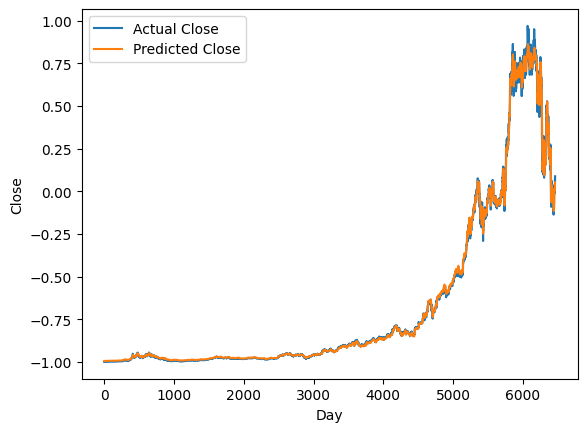

In [68]:
with torch.no_grad():
  predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label="Actual Close")
plt.plot(predicted, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()

In [73]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scalar.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 0.62164058,  0.6206244 ,  0.61987921, ..., 97.51381146,
       99.21276101, 99.78854396])

In [74]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scalar.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91656534e-02, 7.65631105e-02, 7.52590164e-02, ...,
       1.02239998e+02, 1.00550003e+02, 1.03129997e+02])

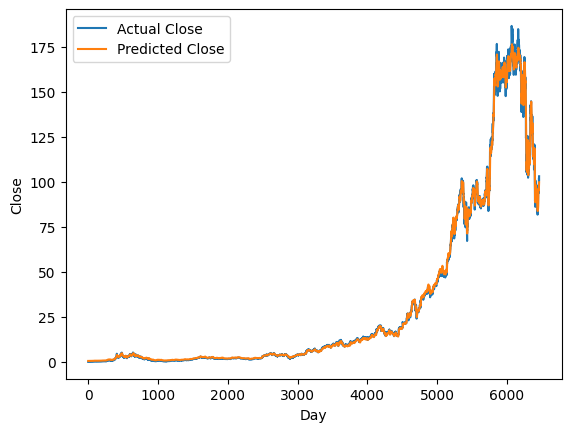

In [77]:
plt.plot(new_y_train, label="Actual Close")
plt.plot(train_predictions, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()

In [80]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scalar.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([101.07232019, 102.65202134, 106.31370593, 105.74383091,
       104.46424501, 103.29501313, 101.51164889,  99.58459719,
        98.09558281,  98.33853526,  98.54024362,  99.31412751,
        99.00626532,  98.31349072,  96.75318727,  95.87387499,
        95.42292376,  94.47736237,  94.06664329,  93.94972363,
        93.26635855,  92.63248977,  93.22011402,  93.4714457 ,
        93.51471509,  93.67485051,  93.26711221,  92.27250898,
        92.00300749,  92.86249867,  94.06664047,  96.33515595,
        97.74796692,  98.12682461,  99.01029757,  98.89551329,
        98.68067649,  98.24449229,  98.01611492,  97.5473566 ,
        98.15784624,  99.4756884 , 100.90397067, 101.64422615,
       102.54374201, 102.09130744, 101.78722205, 101.60639472,
       100.74807497,  99.41485325,  99.95816512, 100.70787528,
       101.32951324, 101.69754582, 102.6319222 , 103.04114242,
       104.19564537, 104.93183897, 104.12343187, 104.15021237,
       105.79831072, 105.67253479, 104.22059535, 103.65

In [81]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scalar.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([105.15000234, 112.91000454, 103.38999889, 102.17999995,
       102.11000087, 100.05000284,  98.23999817,  97.61000092,
        99.54000113,  99.69999717, 101.16000429,  98.15000192,
        97.19999705,  94.580002  ,  95.79000103,  95.82000004,
        93.50000001,  93.76000202,  94.230003  ,  92.16999805,
        92.12999701,  94.900002  ,  93.74999999,  93.55000299,
        93.91999798,  92.24999995,  90.7300031 ,  92.43000005,
        94.879997  ,  96.19999696, 100.0400009 ,  98.94999698,
        97.70999894, 100.61000083,  98.69999691,  98.70999885,
        98.12999699,  98.04000109,  97.23999791, 100.24999993,
       101.99999968, 103.2900007 , 102.41000391, 103.94999723,
       101.09999832, 102.05999789, 102.16999766,  99.91999813,
        97.83000206, 102.40000233, 102.5100021 , 102.73999829,
       102.30000272, 104.30000325, 103.80999835, 106.95999889,
       106.20999869, 102.57000031, 104.98000294, 109.82000009,
       105.44999691, 102.05000266, 103.62999666, 103.65

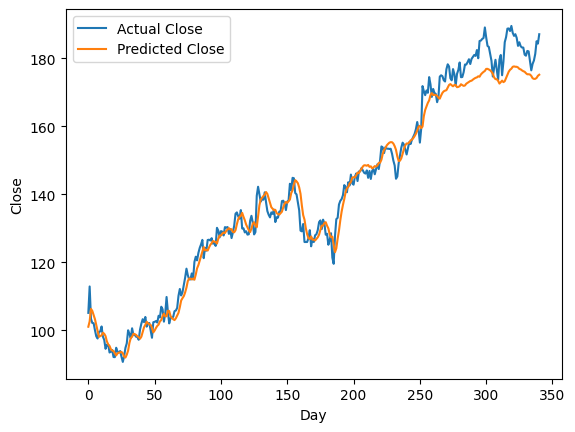

In [82]:
plt.plot(new_y_test, label="Actual Close")
plt.plot(test_predictions, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()